In [291]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf
import statsmodels.api as sm

The assessment will guide you to critically investigate the resilience of the London’s underground as a network and the methodological limitations. You will do this in two ways. In the first part, you will only take into consideration the infrastructural network, where stations are connected through only one link, regardless of the number of lines connecting the stations. In the second part, you will consider the commuting flows, and discuss the impact of the analysis on the number of people moving from one part of the city to another. Then, you will recompute the flows using spatial interaction models according to different scenarios described below and discuss the vulnerability of the network under these new scenarios.    
评估将引导你批判性地调查伦敦地铁作为一个网络的复原力和方法上的局限性。你将通过两种方式完成这一任务。在第一部分，你将只考虑基础设施网络，即车站只通过一个环节连接，而不考虑连接车站的线路数量。在第二部分，你将考虑通勤流，并讨论分析对从城市的一个部分移动到另一个部分的人数的影响。然后，你将根据下面描述的不同情况，使用空间互动模型重新计算流量，并讨论在这些新情况下网络的脆弱性。

# Part 1: London’s underground resilience: 50 marks

## I. Topological network: 34 marks

In [241]:
# G = nx.read_graphml('./data/london_tubenetwork.graphml')
df_csv = pd.read_csv('./data/london_flows.csv')
scaler = MinMaxScaler() 
df_csv['flows_normalized'] = scaler.fit_transform(df_csv[['flows']])

G = nx.Graph()
for i, row in df_csv.iterrows():
    station1 = row['station_origin']
    station2 = row['station_destination']
    flows = row['flows']
    population = row['population']
    jobs = row['jobs']
    distance = row['distance']
    flows_normalized = row['flows_normalized']

    # make 0 as 0.01
    if flows == 0:
        flows = 0.01
    if flows_normalized == 0:
        flows_normalized = 0.0000001
    if population == 0:
        population = 0.01
    if jobs == 0:
        jobs = 0.01

    flows_weight = 1/flows
    flows_normalized_weight = 1 - flows_normalized

    if station1 not in G.nodes:
        G.add_node(station1, station_name = station1)
    if station2 not in G.nodes:
        G.add_node(station2, station_name = station2)
    G.add_edge(station1, station2, flows=flows, flows_weight=flows_weight, 
               flows_normalized=flows_normalized, flows_normalized_weight=flows_normalized_weight, 
               distance=distance, population=population, jobs=jobs)

In [242]:
# show the detail 
df = nx.to_pandas_edgelist(G)
df.head(10)

,source,target,jobs,flows,flows_normalized_weight,flows_weight,flows_normalized,population,distance
0,Abbey Road,Bank and Monument,345.0,0.01,1.000000,100.0,1.000000e-07,29494.0,8131.525097
1,Abbey Road,Beckton,345.0,0.01,1.000000,100.0,1.000000e-07,1179.0,8510.121774
2,Abbey Road,Blackwall,345.0,0.01,1.000000,100.0,1.000000e-07,952.0,3775.448872
3,Abbey Road,Canary Wharf,345.0,2.00,0.999875,0.5,1.254233e-04,14632.0,5086.514220
4,Abbey Road,Canning Town,345.0,5.00,0.999686,0.2,3.135583e-04,21125.0,2228.923167
5,Abbey Road,Crossharbour,345.0,0.01,1.000000,100.0,1.000000e-07,1724.0,6686.475560
6,Abbey Road,Custom House,845.0,0.01,1.000000,100.0,1.000000e-07,599.0,3824.855630
7,Abbey Road,Cutty Sark,345.0,0.01,1.000000,100.0,1.000000e-07,2122.0,8503.898909
8,Abbey Road,Cyprus,345.0,0.01,1.000000,100.0,1.000000e-07,500.0,6532.099618
9,Abbey Road,Devons Road,345.0,0.01,1.000000,100.0,1.000000e-07,1387.0,3958.324171


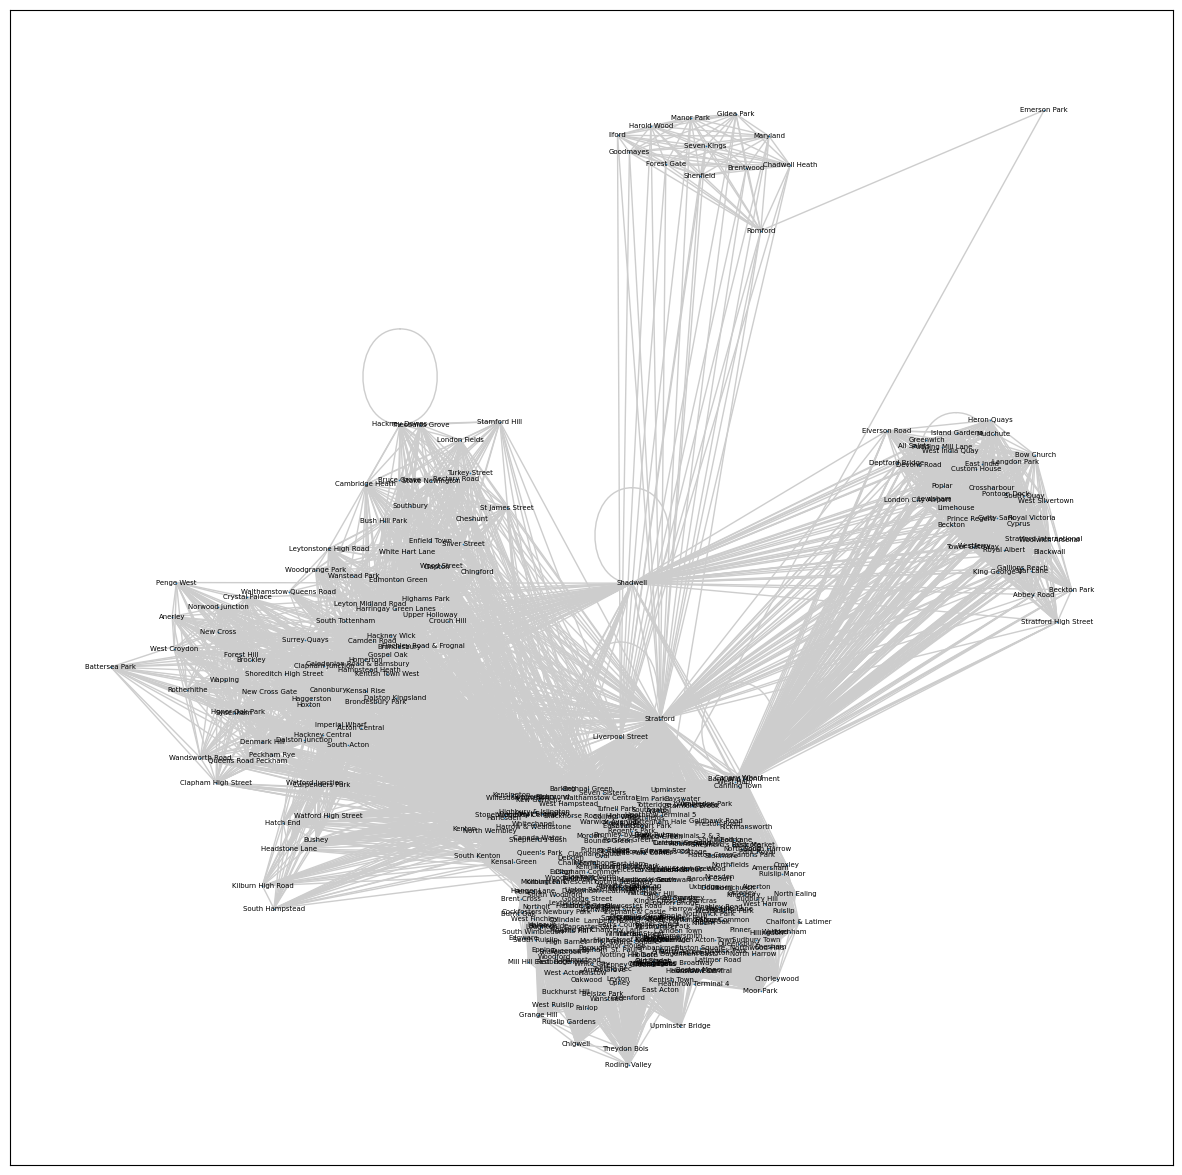

In [243]:
fig, ax = plt.subplots(figsize=(15, 15))
nx.draw_networkx(G, node_size=1,  font_size=5, linewidths=0.1, edge_color="#CDCDCD") # with_labels=False,

### 1.1 Centrality measures:  6 (2 per measure)

Select 3 centrality measures to characterise nodes, aiming at identifying the most important nodes in this particular network. Give the definition of each of the measures (including their equation), put the measures into the context of the underground, and why they will allow you to find the stations that are most crucial for the functioning of the underground. Compute the measures for your nodes in the network, and give the results in a table for the first 10 ranked nodes for each of the 3 measures.   
选择3个中心度量来描述节点的特征，目的是确定这个特定网络中最重要的节点。给出每个衡量标准的定义（包括它们的方程式），把这些衡量标准放在地下的背景中，以及为什么它们能让你找到对地下运作最关键的车站。计算网络中各节点的衡量标准，并在表格中给出3种衡量标准中排名前10的节点的结果。

#### Degree centrality

度中心性（Degree Centrality）是一种常用的中心性指标，用于衡量网络中节点的重要性或中心性。在地铁网络中，度中心性可以用来评估车站的交互性，即与其他车站直接连接的数目。度中心性衡量了节点在网络中的直接连接数目，即节点的度数。节点的度数越高，表示与其他节点有更多的直接连接，从而在网络中起着更重要的作用。    
对于一个无向网络中的节点 $i$，度中心性（Degree Centrality）可以通过以下公式计算：
$$C_{d}(i) = \frac{k_i}{N-1} $$
其中，$C_d(i)$ 表示节点 i 的度中心性，$k_i$ 表示节点 i 的度数（即与节点 i 直接连接的边的数目），$N$ 表示网络中节点的总数。

The degree centrality values are normalized by dividing by the maximum possible degree in a simple graph n-1 where n is the number of nodes in G.   

In [244]:
# Topological Degree centrality
degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G,dict(degree_centrality),'degree_centrality')
# type(degree_centrality)

dc_tube = pd.DataFrame(index=G.nodes())
dc_tube['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
dc_tube['degree_centrality'] = pd.Series(nx.get_node_attributes(G, 'degree_centrality'))
dc_tube = dc_tube.sort_values(["degree_centrality"], ascending=False).reset_index(drop=True)
# dc_tube.head(10)


#### Topological closeness centrality

接近中心性（Closeness Centrality）是一种用来衡量网络中节点与其他节点之间紧密程度的指标。接近中心性衡量了节点到其他节点的平均最短路径长度，即节点与其他节点之间的平均距离。节点的接近中心性越高，表示节点与其他节点之间的距离越短，连接越紧密。 在地铁网络中，Closeness Centrality表示着一个站点到达其他站点的平均最短路径，该值越高，说明该站点在网络中到达其余站点的路程越短，该站点越重要。
$$C_{c}(i) = \frac{N-1}{ {\textstyle \sum_{j=1}^{N}} d(i,j)} $$
其中，$C_c(i)$ 表示节点 i 的接近中心性，$d(i,j)$ 表示节点 i 到节点 j 的最短路径长度，$N$ 表示网络中节点的总数。

In [245]:
# Topological closeness centrality
closeness_centrality = nx.closeness_centrality(G) 
nx.set_node_attributes(G,dict(closeness_centrality),'closeness_centrality')
# type(closeness_centrality)

cc_tube = pd.DataFrame(index=G.nodes())
cc_tube['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
cc_tube['closeness_centrality'] = pd.Series(nx.get_node_attributes(G, 'closeness_centrality'))
cc_tube = cc_tube.sort_values(["closeness_centrality"], ascending=False).reset_index(drop=True)
# cc_tube.head(10)

#### Topological betweenness centrality

节点的中介中心性（Betweenness Centrality）用于衡量节点在网络中充当中介角色的程度，即节点在连接其他节点之间的最短路径上的频率。中介中心性较高的节点通常在网络中具有较强的信息传递和控制能力。中介中心性衡量了节点在网络中作为中介节点的程度，即节点在网络中连接其他节点之间的重要性。节点的中介中心性越高，表示节点在网络中充当中介角色的频率越高，对网络的连接和信息传递起着重要作用。
$$C_B(v) =\sum_{s,t \in V} \frac{\sigma(s, t|v)}{\sigma(s, t)}$$

where $V$ is the set of nodes.
$\sigma(s, t)$ is the number of shortest $(s, t)$-paths, and $\sigma(s, t|v)$ is the number of those paths passing through some node $v$ other than $s,t$.
if $s=t, \sigma(s, t)=1$ and if $v \in {s, t}, \sigma(s, t|v) = 0$



其中，$C_B(v)$ 表示节点 i 的中介中心性，$\sigma_{st}(i)$ 表示节点 i 作为中介节点时，节点 s 到节点 t 的最短路径经过节点 i 的数量，$\sigma_{st}$ 表示节点 s 到节点 t 的最短路径的总数。

In [246]:
# Topological betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G,normalized=True)
nx.set_node_attributes(G,dict(betweenness_centrality),'betweenness_centrality')
# type(betweenness_centrality)

bc_tube = pd.DataFrame(index=G.nodes())
bc_tube['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
bc_tube['betweenness_centrality'] = pd.Series(nx.get_node_attributes(G, 'betweenness_centrality'))
bc_tube = bc_tube.sort_values(["betweenness_centrality"], ascending=False).reset_index(drop=True)
# bc_tube.head(10)

#### Total

In [247]:
merged_df = pd.concat([dc_tube, cc_tube, bc_tube], axis=1)
merged_df.head(10)

,station_name,degree_centrality,station_name,closeness_centrality,station_name,betweenness_centrality
0,Stratford,0.922111,Stratford,0.927739,Stratford,0.098553
1,Highbury & Islington,0.806533,Highbury & Islington,0.836134,Liverpool Street,0.034307
2,Whitechapel,0.781407,Whitechapel,0.820619,Canary Wharf,0.027956
3,West Brompton,0.776382,West Brompton,0.817248,Bank and Monument,0.027956
4,Canada Water,0.771357,Canada Water,0.813906,Canning Town,0.027757
5,Canary Wharf,0.771357,Richmond,0.810591,West Ham,0.024551
6,Liverpool Street,0.768844,Canary Wharf,0.810591,Highbury & Islington,0.023023
7,Bank and Monument,0.766332,Bank and Monument,0.810591,Whitechapel,0.019682
8,Richmond,0.766332,Liverpool Street,0.808943,Canada Water,0.017898
9,Canning Town,0.763819,Canning Town,0.808943,Shadwell,0.017070


### 1.2 Impact measures:  8 (4 per measure)

Find 2 different measures to evaluate the impact of the node removal on the network. These need to be global measures referring to the whole network and not to specific nodes or links. Explain whether these two measures are specific to the London underground, or whether they could also be used to evaluate the resilience of any other network.   
找到2种不同的措施来评估删除节点对网络的影响。这些需要是指整个网络的全局性措施，而不是指具体的节点或链接。解释这两种措施是否专门针对伦敦地铁，或者它们是否也可用于评估任何其他网络的复原力。

评价方法：网络级聚类系数（Network-level Clustering coefficient）、degree_assortativity_coefficient(度同配系数)  

平均聚类系数(average clustering coefficient)反映了网络中所有节点的聚集系数的平均值。聚集系数是一个度量节点与其邻居之间连接紧密程度的指标，它衡量的是一个节点的邻居之间的连通性。对于地铁网络，一个车站的邻居是与它相邻的其他车站，因此聚集系数反映了地铁网络中车站之间的连接紧密程度。平均聚集系数越高，说明地铁网络中车站之间的连接越紧密。   

度同配系数(degree assortativity coefficient)直接反映了网络中节点度数之间的相关性，间接反映了网络的结构特征。对于地铁网络，如果地铁网络中存在正度同配性，那么相邻的站点通常会连接着相似数量的其他站点，形成一个紧密相连的社区结构。反之，如果地铁网络中存在负度同配性，那么相邻的站点通常会连接着数量差异较大的其他站点，形成一个较为分散的结构。   
   
通过对节点进行删除和重新计算两个指标，可以通过两个指标的变化来判断网络的韧性。如果不变或升高，说明网络的韧性较强，也就是说网络能够尽可能的保留原有的特征。如果指标下降，那么说明在对应指标上，网络的韧性不佳，或者说该节点对于网路的影响较大。   
    
这两种测量方法在一定程度上可以反映任意网络的形态和聚集特征，并不是针对伦敦地铁网络。对于使用这两种指标评估任意网络的复原力是否会有显著的效果，我们需要综合考虑网络的自身特征等因素。比如：如果我们更关注一个网络在聚集程度上的韧性变化，那么对于任意网络我们会更加倾向于关注，在节点变化时，该网络的平均聚集系数变化。

In [248]:
# Average_clustering
average_clustering = nx.algorithms.cluster.average_clustering(G)
average_clustering

0.8461409018249689

In [249]:
# degree_assortativity_coefficient
degree_assortativity_coefficient = nx.algorithms.assortativity.degree_assortativity_coefficient(G)
degree_assortativity_coefficient

0.2878494776110778

### 1.3 Node removal: 20

For each of the centrality measures selected in 1.- remove at least 10 nodes following two different strategies. A) Non-sequential removal: using your table in 1.- remove 1 node at a time following the rank in the table, i.e. from the most important one to the 10th most important one. After each removal, evaluate the impact of the removal using your two measures in 2.-, and proceed until you have removed at least 10 nodes. B) Sequential: remove the highest ranked node and evaluate the impact using the 2 measures. After removal, re-compute the centrality measure. Remove the highest ranked node in the new network and evaluate the impact. Continue until removing at least 10 nodes. Report the results of the 2 strategies in one plot, and critically discuss the following: which centrality measure reflects better the importance of a station for the functioning of the underground, which strategy is more effective at studying resilience, and which impact measure is better at assessing the damage after node removal. 

对于在1.中选择的每个中心度量，按照两种不同的策略至少删除10个节点。   
A) 非连续删除：使用你在1.-中的表格，按照表格中的排名一次删除一个节点，即从最重要的一个到第10个最重要的一个。每次删除后，使用2.-中的两个措施评估删除的影响，并继续进行，直到你删除了至少10个节点。   
B) 顺序：删除排名最高的节点，并使用2种措施评估其影响。删除后，重新计算中心性度量。删除新网络中排名最高的节点并评估其影响。继续下去，直到删除至少10个节点。    
在一张图中报告2种策略的结果，并批判性地讨论以下问题：哪种中心性度量能更好地反映一个车站对地下运行的重要性，哪种策略在研究复原力方面更有效，哪种影响度量能更好地评估节点移除后的损害。

In [250]:
def get_nonseq_removal_table(G, mode):
    df = pd.DataFrame(columns=["deleted_station_id", "centrality_value", "average_clustering", "degree_assortativity_coefficient"])
    G2 = nx.Graph(G)
    
    if mode == "degree_centrality":
        centrality = nx.degree_centrality(G2)
    elif mode == "closeness_centrality":
        centrality = nx.closeness_centrality(G2)
    elif mode == "betweenness_centrality":
        centrality = nx.betweenness_centrality(G2)
    else:
        return "Invalid mode"
    sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

    for i in range(10):
            node_to_delete = sorted_nodes[i][0]
            G2.remove_node(node_to_delete)
            average_clustering = nx.average_clustering(G2)
            degree_assortativity_coefficient = nx.degree_assortativity_coefficient(G2)
            df = pd.concat([df, pd.DataFrame({"deleted_station_id": [node_to_delete],
                                              "centrality_value": [sorted_nodes[i][1]],
                                              "average_clustering": [average_clustering],
                                              "degree_assortativity_coefficient": [degree_assortativity_coefficient]})],
                                              ignore_index=True)
    return df

In [271]:
def get_nonseq_removal_table_weight(G, mode, weight1="flows", weight2="flows"):
    df = pd.DataFrame(columns=["deleted_station_id", "centrality_value_weight", "average_clustering_weight", "degree_assortativity_coefficient_weight"])
    G2 = nx.Graph(G)
    
    if mode == "degree_centrality":
        centrality = nx.degree_centrality(G2)
    elif mode == "closeness_centrality":
        centrality = nx.closeness_centrality(G2, weight=weight1)
    elif mode == "betweenness_centrality":
        centrality = nx.betweenness_centrality(G2, weight=weight1)
    else:
        return "Invalid mode"
    sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

    for i in range(10):
            node_to_delete = sorted_nodes[i][0]
            G2.remove_node(node_to_delete)
            average_clustering = nx.average_clustering(G2, weight=weight2)
            degree_assortativity_coefficient = nx.degree_assortativity_coefficient(G2, weight=weight2)
            df = pd.concat([df, pd.DataFrame({"deleted_station_id": [node_to_delete],
                                              "centrality_value_weight": [sorted_nodes[i][1]],
                                              "average_clustering_weight": [average_clustering],
                                              "degree_assortativity_coefficient_weight": [degree_assortativity_coefficient]})],
                                              ignore_index=True)
    return df

In [274]:
def get_seq_removal_table(G, mode):
    df = pd.DataFrame(columns=["deleted_station_id", "centrality_value", "average_clustering", "degree_assortativity_coefficient"])
    G2 = nx.Graph(G)
    
    if mode == "degree_centrality":
        centrality_func = nx.degree_centrality
    elif mode == "closeness_centrality":
        centrality_func = nx.closeness_centrality
    elif mode == "betweenness_centrality":
        centrality_func = nx.betweenness_centrality
    else:
        return "Invalid mode"
    for i in range(10):
            sorted_nodes = sorted(centrality_func(G2).items(), key=lambda x: x[1], reverse=True)
            node_to_delete = sorted_nodes[0][0]
            G2.remove_node(node_to_delete)
            average_clustering = nx.average_clustering(G2)
            degree_assortativity_coefficient = nx.degree_assortativity_coefficient(G2)
            df = pd.concat([df, pd.DataFrame({"deleted_station_id": [node_to_delete],
                                              "centrality_value": [sorted_nodes[0][1]],
                                              "average_clustering": [average_clustering],
                                              "degree_assortativity_coefficient": [degree_assortativity_coefficient]})],
                                              ignore_index=True)
    return df


In [273]:
def get_seq_removal_table_weight(G, mode, weight1="flows", weight2="flows"):
    df = pd.DataFrame(columns=["deleted_station_id", "centrality_value_weight", "average_clustering_weight", "degree_assortativity_coefficient_weight"])
    G2 = nx.Graph(G)
    
    if mode == "degree_centrality":
        centrality_func = nx.degree_centrality
    elif mode == "closeness_centrality":
        centrality_func = nx.closeness_centrality
    elif mode == "betweenness_centrality":
        centrality_func = nx.betweenness_centrality
    else:
        return "Invalid mode"
    for i in range(10):
            sorted_nodes = sorted(centrality_func(G2, weight=weight1).items(), key=lambda x: x[1], reverse=True)
            node_to_delete = sorted_nodes[0][0]
            G2.remove_node(node_to_delete)
            average_clustering = nx.average_clustering(G2, weight=weight2)
            degree_assortativity_coefficient = nx.degree_assortativity_coefficient(G2, weight=weight2)
            df = pd.concat([df, pd.DataFrame({"deleted_station_id": [node_to_delete],
                                              "centrality_value_weight": [sorted_nodes[0][1]],
                                              "average_clustering_weight": [average_clustering],
                                              "degree_assortativity_coefficient_weight": [degree_assortativity_coefficient]})],
                                              ignore_index=True)
    return df


#### A) Non-sequential removal:

In [252]:
dc_nonseq_removal_table = get_nonseq_removal_table(G, "degree_centrality")
dc_nonseq_removal_table

,deleted_station_id,centrality_value,average_clustering,degree_assortativity_coefficient
0,Stratford,0.922111,0.845247,0.318954
1,Highbury & Islington,0.806533,0.844518,0.331850
2,Whitechapel,0.781407,0.843820,0.341482
3,West Brompton,0.776382,0.843457,0.351806
4,Canary Wharf,0.771357,0.842905,0.360748
5,Canada Water,0.771357,0.842080,0.369816
6,Liverpool Street,0.768844,0.841604,0.379064
7,Bank and Monument,0.766332,0.841012,0.388914
8,Richmond,0.766332,0.840537,0.400930
9,Canning Town,0.763819,0.839916,0.411489


In [253]:
cc_nonseq_removal_table = get_nonseq_removal_table(G, "closeness_centrality")
cc_nonseq_removal_table

,deleted_station_id,centrality_value,average_clustering,degree_assortativity_coefficient
0,Stratford,0.927739,0.845247,0.318954
1,Highbury & Islington,0.836134,0.844518,0.331850
2,Whitechapel,0.820619,0.843820,0.341482
3,West Brompton,0.817248,0.843457,0.351806
4,Canada Water,0.813906,0.842637,0.360552
5,Bank and Monument,0.810591,0.842080,0.369575
6,Canary Wharf,0.810591,0.841493,0.379297
7,Richmond,0.810591,0.841015,0.390853
8,Canning Town,0.808943,0.840399,0.400999
9,Liverpool Street,0.808943,0.839916,0.411489


In [254]:
bc_nonseq_removal_table = get_nonseq_removal_table(G, "betweenness_centrality")
bc_nonseq_removal_table

,deleted_station_id,centrality_value,average_clustering,degree_assortativity_coefficient
0,Stratford,0.098553,0.845247,0.318954
1,Liverpool Street,0.034307,0.844742,0.326372
2,Bank and Monument,0.027956,0.844201,0.334331
3,Canary Wharf,0.027956,0.843630,0.342888
4,Canning Town,0.027757,0.843033,0.351457
5,West Ham,0.024551,0.842841,0.358271
6,Highbury & Islington,0.023023,0.842107,0.373238
7,Whitechapel,0.019682,0.841400,0.384574
8,Canada Water,0.017898,0.840572,0.394525
9,Shadwell,0.017070,0.840972,0.391025


#### B) Sequential removal:

In [255]:
dc_seq_removal_table = get_seq_removal_table(G, 'degree_centrality')
dc_seq_removal_table

,deleted_station_id,centrality_value,average_clustering,degree_assortativity_coefficient
0,Stratford,0.922111,0.845247,0.318954
1,Highbury & Islington,0.806045,0.844518,0.331850
2,Whitechapel,0.780303,0.843820,0.341482
3,West Brompton,0.774684,0.843457,0.351806
4,Canary Wharf,0.769036,0.842905,0.360748
5,Canada Water,0.768448,0.842080,0.369816
6,Liverpool Street,0.765306,0.841604,0.379064
7,Bank and Monument,0.762148,0.841012,0.388914
8,Richmond,0.761538,0.840537,0.400930
9,Canning Town,0.758355,0.839916,0.411489


In [256]:
cc_seq_removal_table = get_seq_removal_table(G, "closeness_centrality")
cc_seq_removal_table

,deleted_station_id,centrality_value,average_clustering,degree_assortativity_coefficient
0,Stratford,0.927739,0.845247,0.318954
1,Highbury & Islington,0.835789,0.844518,0.331850
2,Whitechapel,0.819876,0.843820,0.341482
3,West Brompton,0.816116,0.843457,0.351806
4,Canada Water,0.812371,0.842637,0.360552
5,Bank and Monument,0.808642,0.842080,0.369575
6,Canary Wharf,0.808247,0.841493,0.379297
7,Richmond,0.807851,0.841015,0.390853
8,Canning Town,0.805785,0.840399,0.400999
9,Liverpool Street,0.802062,0.839916,0.411489


In [257]:
bc_seq_removal_table = get_seq_removal_table(G, "betweenness_centrality")
bc_seq_removal_table

,deleted_station_id,centrality_value,average_clustering,degree_assortativity_coefficient
0,Stratford,0.098553,0.845247,0.318954
1,Liverpool Street,0.070415,0.844742,0.326372
2,Upminster,0.063741,0.842781,0.328387
3,Bank and Monument,0.038087,0.842236,0.336381
4,Canary Wharf,0.051103,0.841662,0.344978
5,Canning Town,0.077786,0.841062,0.353587
6,West Ham,0.135600,0.840870,0.360432
7,Shadwell,0.173609,0.841341,0.357411
8,Highbury & Islington,0.025566,0.840562,0.372494
9,Whitechapel,0.024413,0.839827,0.383745


#### Disscustion

In [258]:
# 将DataFrame按照 centrality 类型分成三组
dc_nonseq = dc_nonseq_removal_table.copy()
dc_seq = dc_seq_removal_table.copy()

cc_nonseq = cc_nonseq_removal_table.copy()
cc_seq = cc_seq_removal_table.copy()

bc_nonseq = bc_nonseq_removal_table.copy()
bc_seq = bc_seq_removal_table.copy()

# 将每个DataFrame重置索引并去除 deleted_station_id 字段
dc_nonseq = dc_nonseq.drop(columns=['deleted_station_id']).reset_index(drop=True)
dc_seq = dc_seq.drop(columns=['deleted_station_id']).reset_index(drop=True)

cc_nonseq = cc_nonseq.drop(columns=['deleted_station_id']).reset_index(drop=True)
cc_seq = cc_seq.drop(columns=['deleted_station_id']).reset_index(drop=True)

bc_nonseq = bc_nonseq.drop(columns=['deleted_station_id']).reset_index(drop=True)
bc_seq = bc_seq.drop(columns=['deleted_station_id']).reset_index(drop=True)


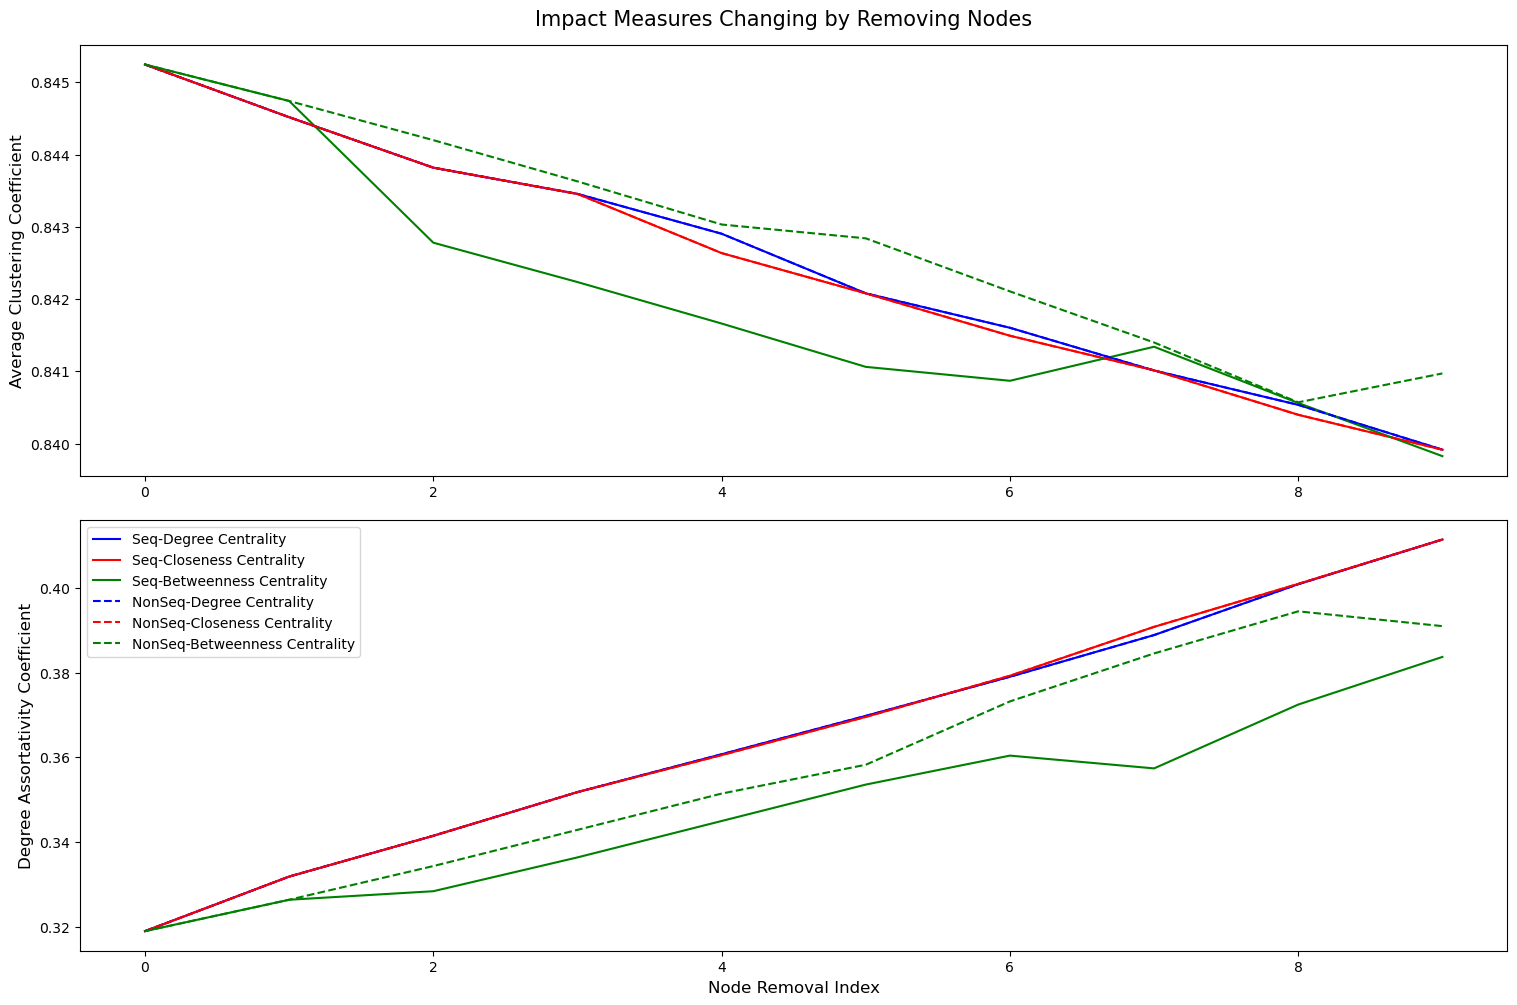

In [259]:
# 设置图形大小、标题、子图布局和坐标轴标签
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
plt.suptitle("Impact Measures Changing by Removing Nodes", fontsize=15)
fig.tight_layout()
axs[0].set_ylabel('Average Clustering Coefficient', fontsize=12)
axs[1].set_ylabel('Degree Assortativity Coefficient', fontsize=12)
axs[1].set_xlabel('Node Removal Index', fontsize=12)

# 绘制子图 1，使用实线表示 seq 的数据，使用虚线表示 nonseq 的数据
axs[0].plot(dc_seq['average_clustering'], label='Degree Centrality (Seq)', color='blue')
axs[0].plot(cc_seq['average_clustering'], label='Closeness Centrality (Seq)', color='red')
axs[0].plot(bc_seq['average_clustering'], label='Betweenness Centrality (Seq)', color='green')
axs[0].plot(dc_nonseq['average_clustering'], '--', label='Degree Centrality (Nonseq)', color='blue')
axs[0].plot(cc_nonseq['average_clustering'], '--', label='Closeness Centrality (Nonseq)', color='red')
axs[0].plot(bc_nonseq['average_clustering'], '--', label='Betweenness Centrality (Nonseq)', color='green')

# 绘制子图 2，使用实线表示 seq 的数据，使用虚线表示 nonseq 的数据
axs[1].plot(dc_seq['degree_assortativity_coefficient'], label='Degree Centrality (Seq)', color='blue')
axs[1].plot(cc_seq['degree_assortativity_coefficient'], label='Closeness Centrality (Seq)', color='red')
axs[1].plot(bc_seq['degree_assortativity_coefficient'], label='Betweenness Centrality (Seq)', color='green')
axs[1].plot(dc_nonseq['degree_assortativity_coefficient'], '--', label='Degree Centrality (Nonseq)', color='blue')
axs[1].plot(cc_nonseq['degree_assortativity_coefficient'], '--', label='Closeness Centrality (Nonseq)', color='red')
axs[1].plot(bc_nonseq['degree_assortativity_coefficient'], '--', label='Betweenness Centrality (Nonseq)', color='green')

axs[1].legend(["Seq-Degree Centrality", "Seq-Closeness Centrality", "Seq-Betweenness Centrality", 
            "NonSeq-Degree Centrality", "NonSeq-Closeness Centrality", "NonSeq-Betweenness Centrality"])


## II. Flows: weighted network:  14 marks

In this section, you will include passengers into the underground, and assess whether different measures need to be used when flows are considered. The network to use in this section is the weighted network given to you in the coursework, where the flows of passengers were assigned to the links between stations.   
II.1. Consider the centrality measure derived in I.- indicating the most relevant stations for assessing the vulnerability of the underground. What would you need to do to adjust this measure for a weighted network? Recompute the ranking of the 10 most important nodes according to this adjusted measure. Do you find the same ones as in I.1?   
II.2. Now consider the measure for assessing the impact of node removal. Would you adjust the measure for a weighted network? If yes, how? Propose a different measure that would be better at assessing the impact of closing a station taking into consideration the passengers.   
II.3. Remove only the 3 highest ranked nodes according to the best performing centrality measure found in I.1. Evaluate the impact according to the 2 measures in II.2. Repeat the experiment for the highest 3 ranked nodes using the adjusted measure. Critically discuss which station closure will have the largest impact on passengers, referring to your measures and results.   

在本节中，你将把乘客纳入地下，并评估在考虑**流量**时是否需要使用不同的措施。本节中要使用的网络是课件中给你的加权网络，其中乘客的流量被分配到车站之间的链接。    
II.1. 考虑在I.-中得出的中心度量，表明与评估地铁的脆弱性最相关的车站。对于加权网络，你需要做什么来调整这个度量？根据这个调整后的措施，重新计算10个最重要的节点的排名。你是否发现与I.1中的相同？   
II.2. 现在考虑用于评估节点移除影响的措施。你会为一个加权网络调整该措施吗？如果是的话，如何调整？提出一个不同的措施，在考虑到乘客的情况下，能更好地评估关闭车站的影响。  
II.3. 根据I.1中发现的最佳表现的中心性度量，只删除排名最高的三个节点。根据II.2中的2个衡量标准评估其影响。使用调整后的措施对排名最高的3个节点进行重复实验。参照你的措施和结果，批判性地讨论哪一个车站关闭对乘客的影响最大。  

### II.1. Old vs new measure: 3

In [260]:
# Closeness centrality
closeness_centrality = nx.closeness_centrality(G, distance='flows_normalized_weight') 
nx.set_node_attributes(G,dict(closeness_centrality),'closeness_centrality_weight')
# type(closeness_centrality)

cc_tube_weight = pd.DataFrame(index=G.nodes())
cc_tube_weight['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
cc_tube_weight['closeness_centrality_weight'] = pd.Series(nx.get_node_attributes(G, 'closeness_centrality_weight'))
cc_tube_weight = cc_tube_weight.sort_values(["closeness_centrality_weight"], ascending=False).reset_index(drop=True)
# cc_tube_weight.head(10)

In [261]:
# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G,weight='flows_normalized_weight')
nx.set_node_attributes(G,dict(betweenness_centrality),'betweenness_centrality_weight')
# type(betweenness_centrality)

bc_tube_weight = pd.DataFrame(index=G.nodes())
bc_tube_weight['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
bc_tube_weight['betweenness_centrality_weight'] = pd.Series(nx.get_node_attributes(G, 'betweenness_centrality_weight'))
bc_tube_weight = bc_tube_weight.sort_values(["betweenness_centrality_weight"], ascending=False).reset_index(drop=True)
# bc_tube_weight.head(10)

In [262]:
merged_df_weight = pd.concat([cc_tube, cc_tube_weight, bc_tube, bc_tube_weight], axis=1)
merged_df_weight.head(10)

,station_name,closeness_centrality,station_name,closeness_centrality_weight,station_name,betweenness_centrality,station_name,betweenness_centrality_weight
0,Stratford,0.927739,Stratford,0.944876,Stratford,0.098553,Stratford,0.132384
1,Highbury & Islington,0.836134,Liverpool Street,0.869680,Liverpool Street,0.034307,Bank and Monument,0.125460
2,Whitechapel,0.820619,Highbury & Islington,0.851008,Canary Wharf,0.027956,Canada Water,0.063178
3,West Brompton,0.817248,Canary Wharf,0.847229,Bank and Monument,0.027956,Liverpool Street,0.061327
4,Canada Water,0.813906,Bank and Monument,0.838551,Canning Town,0.027757,Waterloo,0.046047
5,Richmond,0.810591,Waterloo,0.838551,West Ham,0.024551,Highbury & Islington,0.028894
6,Canary Wharf,0.810591,Whitechapel,0.827934,Highbury & Islington,0.023023,Seven Sisters,0.024588
7,Bank and Monument,0.810591,Canada Water,0.826647,Whitechapel,0.019682,Barking,0.021002
8,Liverpool Street,0.808943,Canning Town,0.823384,Canada Water,0.017898,Canning Town,0.019432
9,Canning Town,0.808943,West Brompton,0.822428,Shadwell,0.017070,Canary Wharf,0.017379


### II.2. Impact measure with flows: 3

In [267]:
# Average_clustering_weight
average_clustering_weight = nx.algorithms.cluster.average_clustering(G, weight='flows_normalized')
average_clustering_weight

0.0005543817457936487

In [265]:
# degree_assortativity_coefficient
degree_assortativity_coefficient_weight = nx.algorithms.assortativity.degree_assortativity_coefficient(G, weight='flows_normalized')
degree_assortativity_coefficient_weight

-0.03774129197190707

平均最短路径长度（Average shortest path length）：所有节点对之间的最短路径长度的平均值。一般来说，平均最短路径长度越小，说明节点之间的联系越紧密，信息传播的速度越快。
对于London地铁网络，该值越小，说明旅客从出发地到目的地所需要经过的站点数量越少。

In [270]:
# average_shortest_path_length
average_shortest_path_length_weight = nx.average_shortest_path_length(G, weight='flows_normalized_weight')
average_shortest_path_length_weight

1.589256953706221

### III.3. Experiment with flows: 8

In [275]:
bc_nonseq_removal_table_weight = get_nonseq_removal_table_weight(G, 'betweenness_centrality', weight1='flows_normalized_weight', weight2='flows_normalized')
bc_nonseq_removal_table_weight

,deleted_station_id,centrality_value_weight,average_clustering_weight,degree_assortativity_coefficient_weight
0,Stratford,0.132384,0.000495,-0.031957
1,Bank and Monument,0.125460,0.000895,-0.035445
2,Canada Water,0.063178,0.000871,-0.032906
3,Liverpool Street,0.061327,0.000795,-0.030939
4,Waterloo,0.046047,0.001011,-0.035138
5,Highbury & Islington,0.028894,0.000996,-0.030802
6,Seven Sisters,0.024588,0.000975,-0.029663
7,Barking,0.021002,0.000976,-0.029385
8,Canning Town,0.019432,0.000948,-0.027147
9,Canary Wharf,0.017379,0.001068,-0.024770


In [276]:
bc_seq_removal_table_weight = get_seq_removal_table_weight(G, 'betweenness_centrality', weight1='flows_normalized_weight', weight2='flows_normalized')
bc_seq_removal_table_weight

,deleted_station_id,centrality_value_weight,average_clustering_weight,degree_assortativity_coefficient_weight
0,Stratford,0.132384,0.000495,-0.031957
1,Bank and Monument,0.173572,0.000895,-0.035445
2,Liverpool Street,0.107691,0.000820,-0.033691
3,Canary Wharf,0.103262,0.001216,-0.034919
4,Canning Town,0.126193,0.001185,-0.032513
5,West Ham,0.143535,0.001185,-0.031963
6,Shadwell,0.179798,0.001160,-0.031411
7,Canada Water,0.067308,0.001123,-0.028118
8,Highbury & Islington,0.069389,0.001104,-0.023300
9,Whitechapel,0.086867,0.001088,-0.020917


In [277]:
bc_nonseq = bc_nonseq_removal_table_weight.copy()
bc_seq = bc_seq_removal_table_weight.copy()

bc_nonseq = bc_nonseq.drop(columns=['deleted_station_id']).reset_index(drop=True)
bc_seq = bc_seq.drop(columns=['deleted_station_id']).reset_index(drop=True)

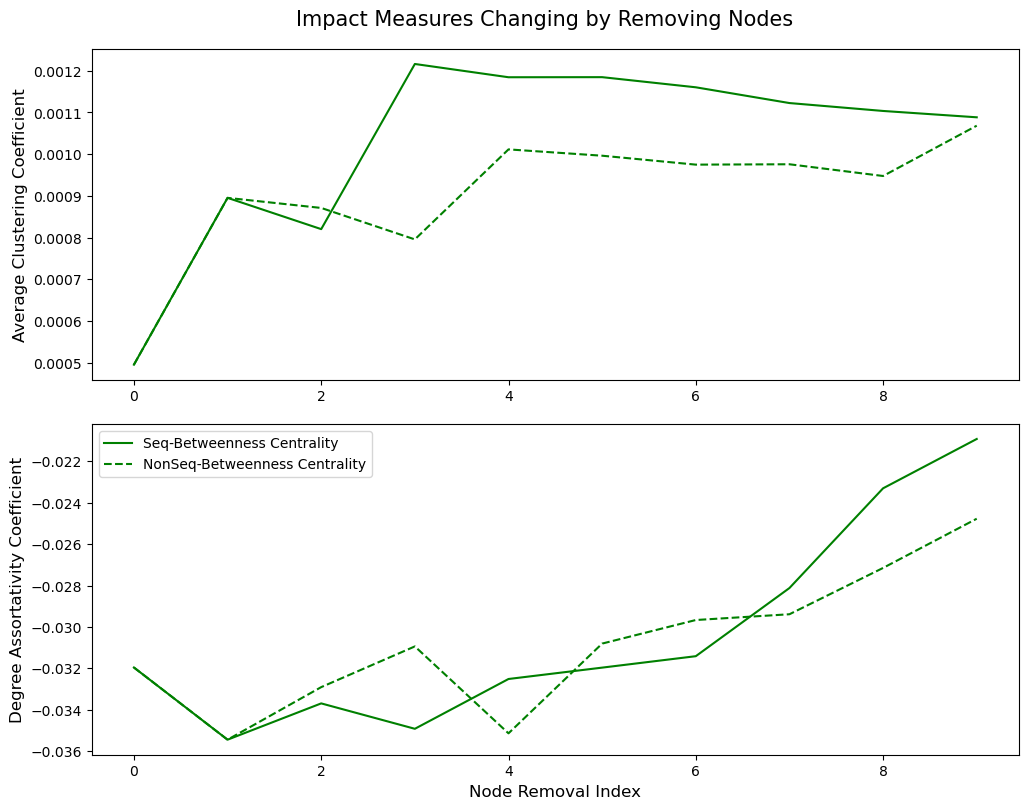

In [282]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.suptitle("Impact Measures Changing by Removing Nodes", fontsize=15)
fig.tight_layout()
axs[0].set_ylabel('Average Clustering Coefficient', fontsize=12)
axs[1].set_ylabel('Degree Assortativity Coefficient', fontsize=12)
axs[1].set_xlabel('Node Removal Index', fontsize=12)

axs[0].plot(bc_seq['average_clustering_weight'], label='Betweenness Centrality (Seq)', color='green')
axs[0].plot(bc_nonseq['average_clustering_weight'], '--', label='Betweenness Centrality (Nonseq)', color='green')

axs[1].plot(bc_seq['degree_assortativity_coefficient_weight'], label='Betweenness Centrality (Seq)', color='green')
axs[1].plot(bc_nonseq['degree_assortativity_coefficient_weight'], '--', label='Betweenness Centrality (Nonseq)', color='green')

axs[1].legend(["Seq-Betweenness Centrality", "NonSeq-Betweenness Centrality"])


# Part 2: Spatial Interaction models: 50 marks

For this section, you will be given a “symbolic” population and the number of jobs for the stations in the underground. You will also be given the number of people that commute from one station to another, through an OD matrix.

在这一部分，你将得到一个 "象征性 "的人口和地下各站的工作数量。你还将通过OD矩阵得到从一个车站到另一个车站的通勤人数。

## III. Models and calibration: 18

### III.1   8

Briefly introduce the spatial interaction models covered in the lectures using equations and defining the terms, taking particular care in explaining the role of the parameters.    
用方程和术语定义简要介绍讲座中涉及的空间互动模型，特别注意解释参数的作用。

####  Gravity model

#### ABM

### III.2 10

Using the information of population, jobs and flows, select a spatial interaction model and calibrate the parameter for the cost function (usually denoted as $\beta$). It is essential that you justify the model selected.    
利用人口、工作和流量的信息，选择一个空间互动模型，校准成本函数的参数（通常表示为$\beta$）。你必须证明所选模型的合理性。   

目标空间互动模型是对某个时间段或空间范围内事件的发生次数进行建模和预测，因此选择使用泊松回归建立预测模型。因为泊松回归模型假设响应变量是泊松分布的，并且对计数数据的建模和预测效果较好。

双约束??

flow总量不变？

$$
\lambda_{ij} = \exp (\alpha_i + \gamma_j - \beta \ln d_{ij})
$$

where $d_{ij}=\frac {D_{ij}}{Pop_i + Jobs_i}$

In [289]:
csv = pd.read_csv('./data/london_flows.csv')
csv.head(2)

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774


In [297]:

df = csv.replace(0, 0.01)
df.head(2)

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0.01,599.0,78549.0,8131.525097
1,Abbey Road,Beckton,1.00,599.0,442.0,8510.121774


In [300]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~ station_origin + station_destination + np.log(distance/(population+jobs))-1'
#run a doubly constrained sim
doubSim = smf.glm(formula = formula, data=df, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doubSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    60676
Model Family:                 Poisson   Df Model:                          797
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1895e+06
Date:                Sun, 30 Apr 2023   Deviance:                   2.2050e+06
Time:                        04:07:11   Pearson chi2:                 4.33e+06
No. Iterations:                    13   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

## IV. Scenarios 30 marks

### IV.1  8

Scenario A: assume that Canary Wharf has a 50% decrease in jobs after Brexit. Using the calibrated parameter $\beta$, compute the new flows for scenario A. Make sure the number of commuters is conserved, and explain how you ensured this.   
情景A：假设金丝雀码头在英国脱欧后工作机会减少50%。使用校准的参数$beta$，计算方案A的新流量，确保通勤者的数量得到保留，并解释你如何确保这一点。

### IV.2  12

Scenario B: assume that there is a significant increase in the cost of transport. Select 2 values for the parameter in the cost function reflecting scenario B. Recompute the distribution of flows.   
情景B：假设运输成本有显著增加。为反映方案B的成本函数中的参数选择2个值，重新计算流量分布。  

### IV.3  10

Discuss how the flows change for the 3 different situations: scenario A, and scenario B with two selections of parameters. Which scenario would have more impact in the redistribution of flows? Explain and justify your answers using the results of the analysis.   
讨论3种不同情况下的流量变化：方案A和方案B的两种参数选择。哪种情况会对流量的重新分配产生更大的影响？用分析的结果来解释和证明你的答案。  